In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from qutip import *
import matplotlib.gridspec as gridspec
from scipy.integrate import trapezoid
from qutip import wigner

In [2]:
N = 20 #Hilbert space cutoff per mode

cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1)).unit()

sq = squeeze(N, z = np.log(1.2))

cat_state_squeezed = (sq * cat_state).unit()

x = np.linspace(-5, 5, 100)

p = np.linspace(-5, 5, 100)

cat_W = wigner(cat_state_squeezed, x, p)

# vi behøves ikke at have density matrices fordi vi har ikke losses med endnu, så derfor kan cat bare være en ket state.

$|CAT\rangle_{1} \otimes |CAT\rangle_{2}$

In [3]:
two_mode_cat_begin = tensor(cat_state_squeezed, cat_state_squeezed)


$BS(\theta) |CAT\rangle_{1} \otimes |CAT\rangle_{2}$

In [4]:
def BS(eta,N1, N2, input_state):
    ## Create a beam splitter operator with angle theta

    a1 = destroy(N1)
    a1dag = a1.dag()
    a2 = destroy(N2)
    a2dag = a2.dag()

    T = 1/eta

    theta = np.arccos(np.sqrt(T))

    x1 = (a1 + a1dag)*1/np.sqrt(2)
    p1 = 1j * (a1dag - a1)*1/np.sqrt(2)
    x2 = (a2 + a2dag)*1/np.sqrt(2)
    p2 = 1j * (a2dag - a2)*1/np.sqrt(2)

    BS = 1j * theta * (tensor(p1, x2) - tensor(x1, p2))

    BSs = BS.expm()  # Exponentiate to get the unitary operator

    if input_state.isket:
        answer = BSs * input_state
    else:
        answer = BSs * input_state * BSs.dag()

    return answer

In [5]:
cat_out_mode1and2 = BS(2, N, N, two_mode_cat_begin)

So now I have a two-mode squeezed cat state after the beam splitter.

I am assuming the P output is 0, which is a squeezed vacuum state, since our fockspace not can be infinite-dimensional.

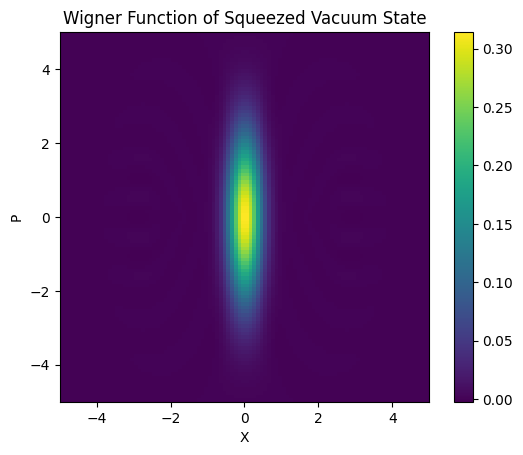

In [23]:
vac = basis(N, 0)
vac_squeezed = squeeze(N, z = np.log(2.2)) * vac.unit()

vac_wigner = wigner(vac_squeezed,x,p)
plt.figure()
plt.imshow(vac_wigner, extent=[-5, 5, -5, 5])
plt.title('Wigner Function of Squeezed Vacuum State')
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.show()

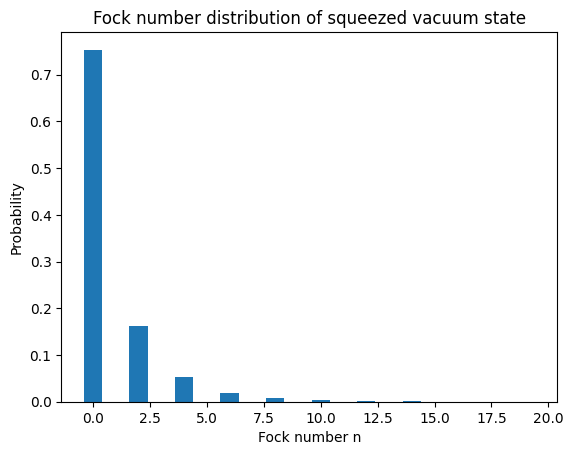

In [24]:
n = np.arange(N)  # Fock numbers
probs = np.abs(vac_squeezed.full())**2  # |<n|psi>|^2
probs = probs.flatten() 
plt.bar(n, probs)
plt.xlabel("Fock number n")
plt.ylabel("Probability")
plt.title("Fock number distribution of squeezed vacuum state")
plt.show()

In [10]:
vac = basis(N, 0)
vac_squeezed = squeeze(N, z = np.log(2.1)) * vac.unit()
p0_DM =  vac_squeezed * vac_squeezed.dag()
p0_DM_full = tensor(qeye(N), p0_DM)  # expand P0_DM
print(cat_out_mode1and2.shape)
cat_out_mode1and2.shape
projection_of_mode_1 = ( p0_DM_full * cat_out_mode1and2).ptrace(1) # 0 is mode 1, and 1 is mode 2




(400, 1)


In [ ]:
def cat_breeding(eta, N = 30):

    #creating squeezed vacuum density matrix and make it N^2 dimensions
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z = np.log(2.2)) * vac.unit()
    vac_DM = vac_squeezed * vac_squeezed.dag()
    vac_DM_full = tensor(qeye(N), vac_DM)  # Projector for mode 2

    #creating two-mode cat state
    cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1)).unit()
    sq = squeeze(N, z = np.log(0.3))
    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    mode_2_list = []
    current_state = cat_state_squeezed

    for i in range(len(eta)):
        if current_state.isket:
            # For ket input
            cat_two = tensor(current_state, cat_state_squeezed)
            # For density matrix input
        else:
            cat_two = tensor(current_state, cat_DM)

        cat_out = BS(eta[i],N, N, cat_two)

        if cat_out.isket:
            # For ket input
            projected = (vac_DM_full * cat_out.proj()).ptrace(1)
        else:
            # For density matrix input
            projected = (vac_DM_full * cat_out).ptrace(1)

        # Update current state and cat_DM for next iteration
        current_state = projected
        if not projected.isket:
            cat_DM = projected

        mode_2_list.append(projected)

    return mode_2_list


In [22]:
eta_list = np.arange(2,7)

cat_states = cat_breeding(eta_list, N=40)

wigner_cat = []

for i in range(len(eta_list)):

        wigner_cat.append(wigner(cat_states[i], x, p))


$H_space = H_{mode 1} \otimes H_{mode 2} => $ all modes must have $N^2$ dimensions 

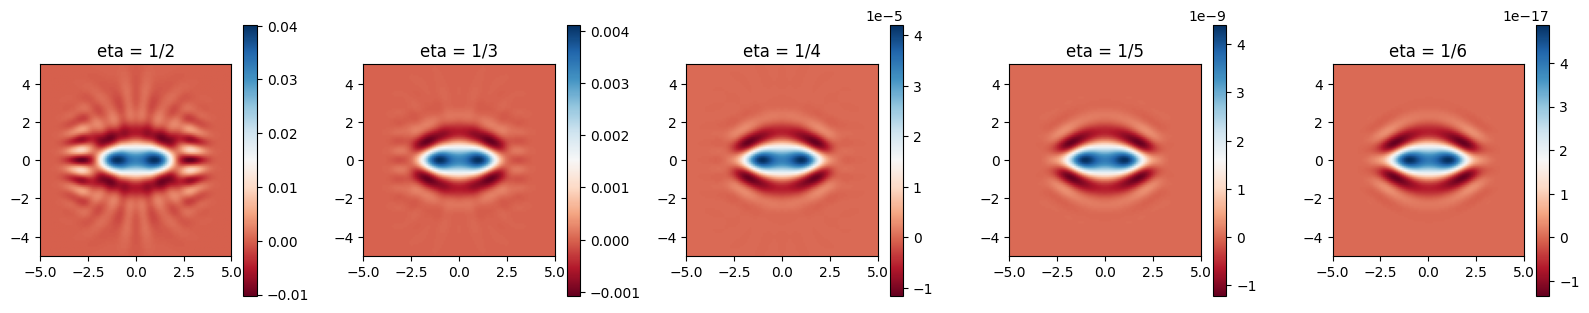

In [21]:
plt.figure(figsize=(16, 12))
for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f"eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat[i], extent=[-5, 5, -5, 5], cmap='RdBu')
    plt.colorbar()
plt.tight_layout()
plt.show()
